# Scentinel Elasticnet Transductive workflow

## Note!! This is a truncated notebook for just the transductive learning steps!
## Removed modules:
- Scentinel Metacell creation module
- VAE integration module
- Neighborhood pruning module
- Classifier model feature assessment module
- Feature impact module

##### Ver:: A0_V2_1
##### Author(s) : Issac Goh
##### Date : 231210;YYMMDD
### Author notes
    - Feel free to feed this model latent representations which capture non-linear relationships, the model will attempt to resolve any linearly seperable features. Feature engineering can be applied here.
    
### Features to add
    - Add ability to consume anndata zar format for sequential learning
    
### Modes to run in
    - Run in train = True for reference data to get a generalisable model
    - Run in train = False for query data to get a set of probabillistic outputs for the query data

In [ ]:
import scanpy as sc
import pandas as pd
import numpy as np
import scentinel as scent
import pickle as pkl
import matplotlib.pyplot as plt


# ¢ new modules
import psutil
import time
import threading
from scipy.interpolate import UnivariateSpline
from queue import Queue, Empty
import scipy

# Let's now run this model in a tansductive format to generalise across across 

## Initialise a new projection run
- Here we generalise the transductive model across the entire dataset
- In this instance, we load the reference data seperatley, and train a supervised classifier

## Load your reference data and train a classifier
#### Mandatory variables to set:
- adata_key -- The key for adata of interest selected from adatas_dict
- freq_redist -- The key for a column in adata.obs which you'd like to treat as a local clustering control (False if not required)
- train_x_partition -- The partition you'd like to train the model on, default is expression data (X)
- model_params['feat_use'] -- The column in adata.obs which you'd like to assign as the classes

In [6]:
# These are pre-trained models that you can use
models = {
    "pan_fetal_wget": "https://celltypist.cog.sanger.ac.uk/models/Pan_Fetal_Suo/v2/Pan_Fetal_Human.pkl",
    "YS_wget": "https://storage.googleapis.com/haniffalab/yolk-sac/YS_X_A2_V12_lvl3_ELASTICNET_YS.sav",
}

adatas_dict = {
    "pan_fetal_wget": "https://cellgeni.cog.sanger.ac.uk/developmentcellatlas/fetal-immune/PAN.A01.v01.raw_count.20210429.PFI.embedding.h5ad",
    "YS_wget": "https://app.cellatlas.io/yolk-sac/dataset/23/download",
    "YS_local": "/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_data/Submission_2_data/A2_V10_scvi_YS_integrated/A2_V10_qc_raw_obsm.h5ad",
    "YS_pre_agm": "https://app.cellatlas.io/yolk-sac/dataset/10/download",
    "FLIV_wget": "https://app.cellatlas.io/fetal-liver/dataset/1/download",
    "YS_local_scent": "/nfs/team205/ig7/projects/YS_organoid/data/YS_scentinel.h5ad",
}

# setup global params:
# Variable assignment
train_model = True
adata_key = "YS_local_scent"  #'fliv_wget_test' # key for dictionary entry containing local or web path to adata/s can be either url or local
data_merge = False  # read and merge multiple adata (useful, but keep false for now)
model_key = "new_example_model"  #'pan_fetal_wget'#'test_low_dim_ipsc_ys'# key for model of choice can be either url or local
freq_redist = False  #'cell.labels'#'False#'cell.labels'#False # False or key of column in anndata object which contains labels/clusters
QC_normalise = False  # should data be normalised?

# setup model parameters:
model_params = {
    "feat_use": "LVL3",
    "train_x_partition": "X",  # what partition was the data trained on?
    "penalty": "elasticnet",  # can be ["l1","l2","elasticnet"],
    "var_length": 7500,
    "batch_key": None,
    "sparcity": 0.5,  # If using LR without optimisation, this controls the sparsity in model C penalty for degree of regularisation
    "max_iter": 1000,  # Increase if experiencing max iter issues
    "thread_num": -1,
    "l1_ratio": 0.5,  # If using elasticnet without optimisation, this controls the ratio between l1 and l2)
    "partial_scale": False,  # should data be scaled in batches?
    "tune_hyper_params": False,  # Current implementation is very expensive, intentionally made rigid for now
    "batch_correction": False,
    "loss": "logloss",
    "sketch_tune": False,  # warning, do not use this if you are already sub-sampling
}

In [ ]:
if train_model == True:
    from sklearn.preprocessing import StandardScaler

    adata = scent.load_adatas(adatas_dict, data_merge, adata_key, QC_normalise)
    import time

    t0 = time.time()
    display_cpu = scent.DisplayCPU()
    display_cpu.start()
    try:
        model_trained = scent.prep_training_data(
            adata_temp=adata, model_key=model_key + "_lr_model", **model_params
        )
        filename = model_name
        pkl.dump(model_trained, open(filename, "wb"))
    finally:  #
        current, peak = display_cpu.stop()
        t1 = time.time()
        time_s = t1 - t0
        print("training complete!")
        time.sleep(3)
        print("projection time was " + str(time_s) + " seconds")
        print(f"Current memory usage is {current / 10**6}MB; Peak was {peak / 10**6}MB")
        print(f"starting memory usage is" + "" + str(display_cpu.starting))
        print("peak CPU % usage = " + "" + str(display_cpu.peak_cpu))
        print("peak CPU % usage/core = " + "" + str(display_cpu.peak_cpu_per_core))
    model_lr = model_trained
    adata = scent.load_adatas(adatas_dict, data_merge, adata_key)
else:
    adata = scent.load_adatas(adatas_dict, data_merge, adata_key, QC_normalise)
    model = scent.load_models(models, model_key)
    model_lr = model

# run with usage logger
import time

t0 = time.time()
display_cpu = scent.DisplayCPU()
display_cpu.start()
try:  # code here ##
    pred_out, train_x, model_lr, adata_temp = scent.reference_projection(
        adata, model_lr, **model_params
    )
    if freq_redist != False:
        pred_out["orig_labels"] = adata.obs[freq_redist]
        pred_out = scent.freq_redist_68CI(pred_out, "orig_labels")
        adata.obs["consensus_clus_prediction"] = pred_out["consensus_clus_prediction"]
    adata.obs["predicted"] = pred_out["predicted"]
    adata_temp.obs = adata.obs

    # Estimate top model features for class descrimination
    feature_importance = scent.estimate_important_features(model_lr, 100)
    mat = feature_importance.euler_pow_mat
    top_loadings = feature_importance.to_n_features_long

finally:  #
    current, peak = display_cpu.stop()
t1 = time.time()
time_s = t1 - t0
print("projection complete!")
time.sleep(3)
print("projection time was " + str(time_s) + " seconds")
print(f"Current memory usage is {current / 10**6}MB; Peak was {peak / 10**6}MB")
print(f"starting memory usage is" + "" + str(display_cpu.starting))
print("peak CPU % usage = " + "" + str(display_cpu.peak_cpu))
print("peak CPU % usage/core = " + "" + str(display_cpu.peak_cpu_per_core))

# Now assess the generalised predictions

                                  precision    recall  f1-score   support

                     DC2_CYCLING       1.00      1.00      1.00         9
                      DEF_HSPC_1       1.00      1.00      1.00       392
                      DEF_HSPC_2       1.00      1.00      1.00         7
                 EARLY_ERYTHROID       1.00      1.00      1.00       369
                             ELP       1.00      1.00      1.00        27
                        ENDODERM       1.00      1.00      1.00       524
                 ENDOTHELIUM_AEC       1.00      1.00      1.00       109
          ENDOTHELIUM_PROLIF_AEC       1.00      1.00      1.00         3
ENDOTHELIUM_PROLIF_SINUSOIDAL_EC       1.00      1.00      1.00        33
          ENDOTHELIUM_SINUSOIDAL       1.00      1.00      1.00        57
                 ENDOTHELIUM_VWF       1.00      1.00      1.00       174
             EOSINOPHIL_BASOPHIL       1.00      1.00      1.00         6
          EO_BASO_MAST_PRECURSOR     

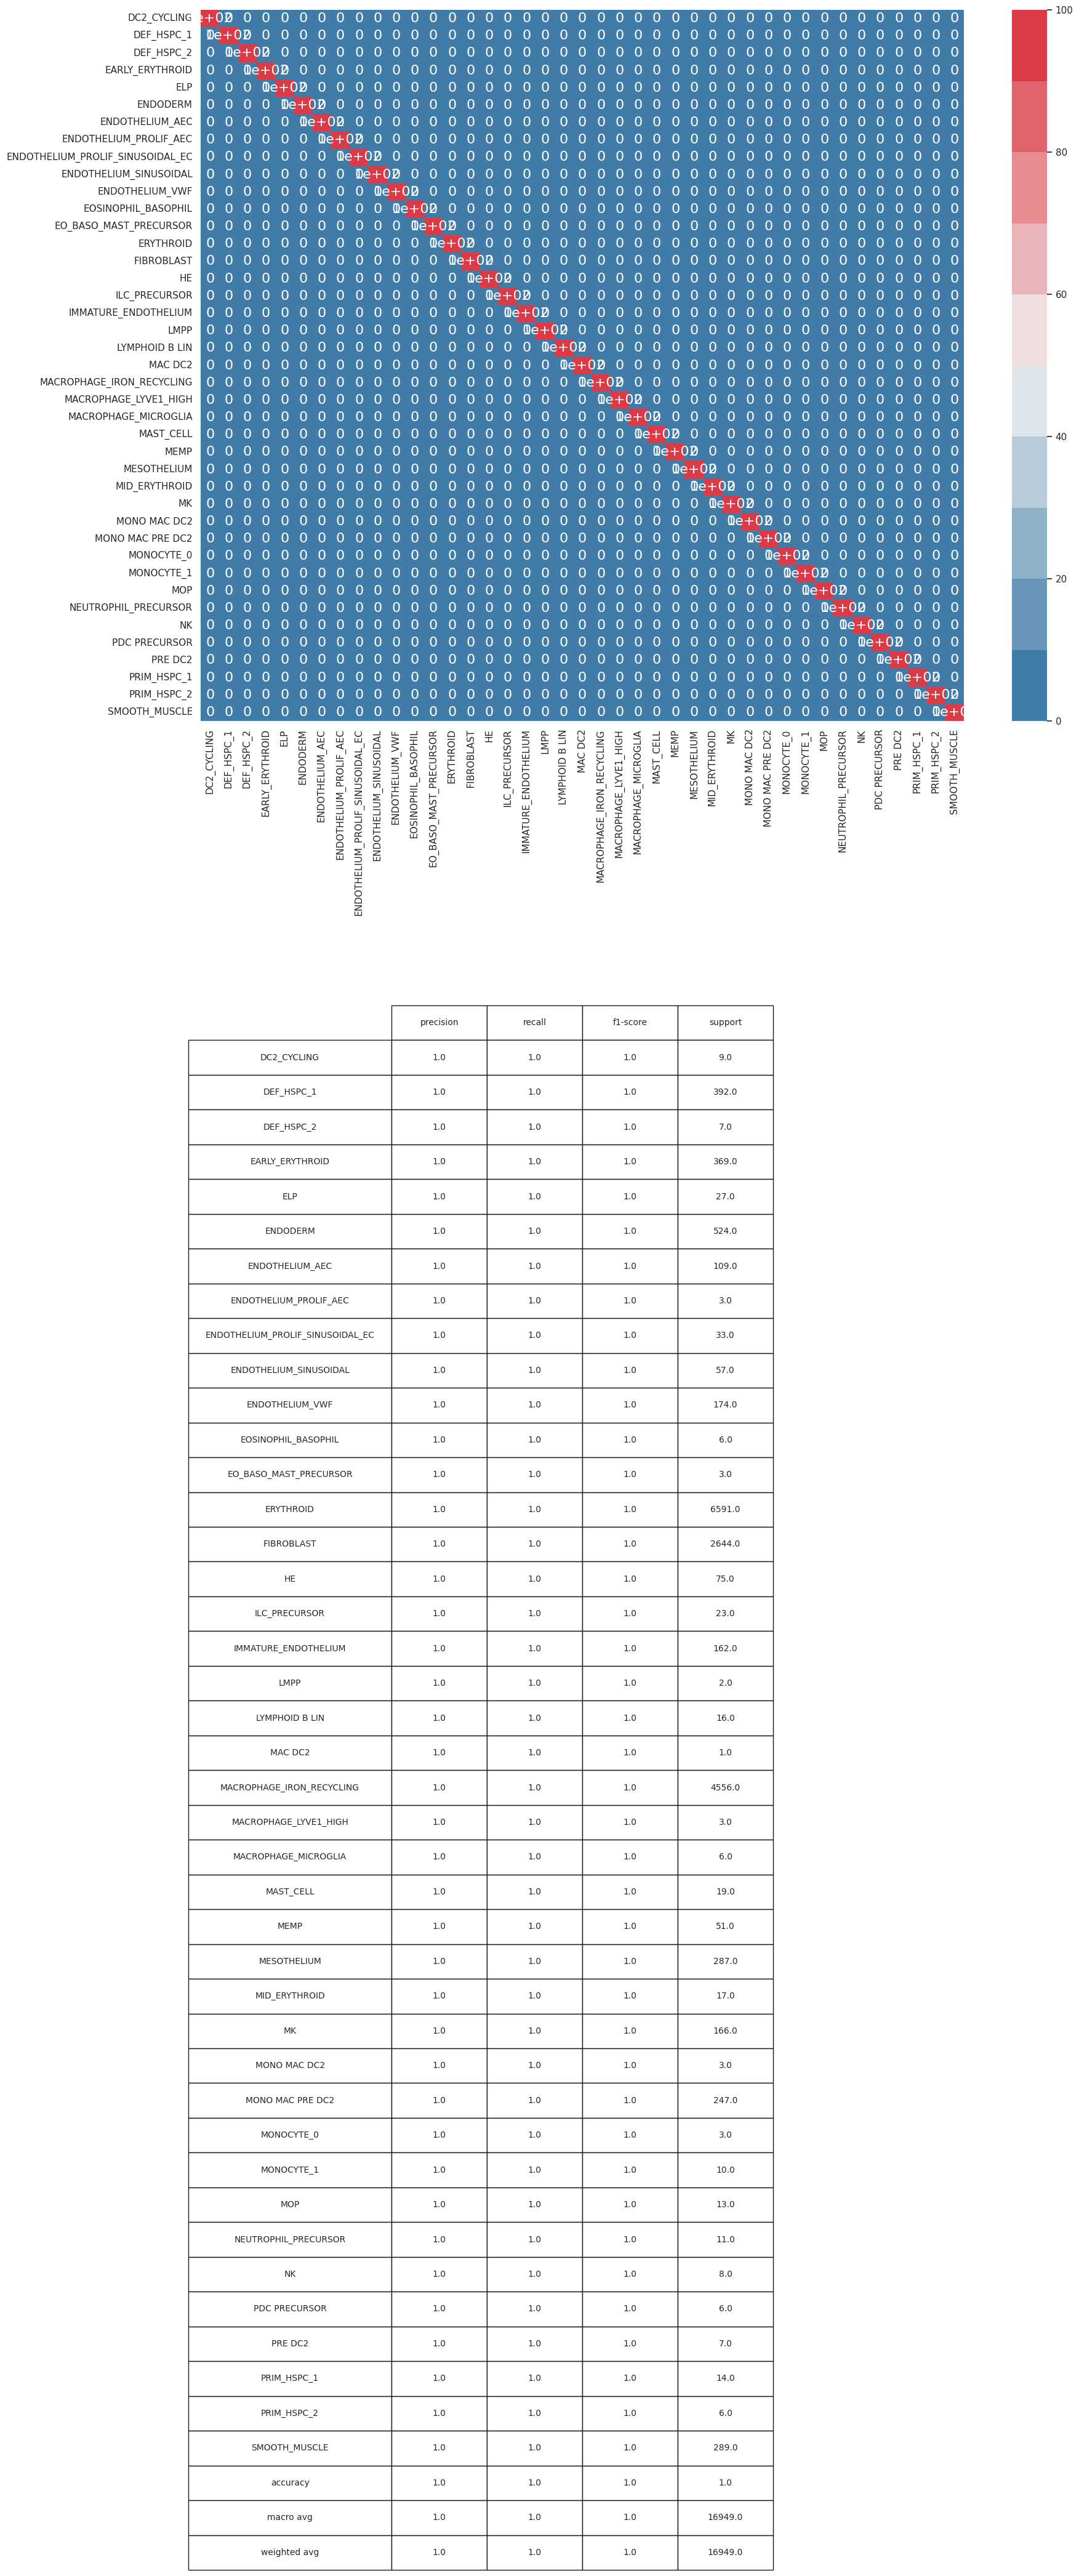

In [18]:
if train_model == True:
    train_label = adata.obs[feat_use].values
else:
    train_label = adata.obs["predicted"].values
scent.report_f1(model_lr, train_x, train_label)

In [20]:
if train_model == True:
    scent.regression_results(
        pred_out, "orig_labels", "predicted", list(model_lr.classes_)
    )
else:
    scent.regression_results(
        pred_out, "predicted", "predicted", list(model_lr.classes_)
    )

Cross entropy loss:  0.6536
mean_squared_log_error:  0.0
MAE:  0.0
MSE:  0.0
RMSE:  0.0
label Cross entropy loss: 
{'DC2_CYCLING': 0.006162638385798672, 'DEF_HSPC_1': 0.036586816327393974, 'DEF_HSPC_2': 0.007843263471799491, 'EARLY_ERYTHROID': 0.04905718363033005, 'ELP': 0.009927527598153602, 'ENDODERM': 0.05276446005688349, 'ENDOTHELIUM_AEC': 0.021377780619422346, 'ENDOTHELIUM_PROLIF_AEC': 0.0035541672511339084, 'ENDOTHELIUM_PROLIF_SINUSOIDAL_EC': 0.007520125228124507, 'ENDOTHELIUM_SINUSOIDAL': 0.012205856174655836, 'ENDOTHELIUM_VWF': 0.02395491311632716, 'EOSINOPHIL_BASOPHIL': 0.0057726964838913635, 'EO_BASO_MAST_PRECURSOR': 0.005112761336798034, 'ERYTHROID': 0.027932300715683523, 'FIBROBLAST': 0.2602227147679683, 'HE': 0.014626903010070516, 'ILC_PRECURSOR': 0.008152439855050193, 'IMMATURE_ENDOTHELIUM': 0.02706025219564707, 'LMPP': 0.005786522629970337, 'LYMPHOID B LIN': 0.006851140715137998, 'MAC DC2': 0.00485531886207841, 'MACROPHAGE_IRON_RECYCLING': 0.16049938290791027, 'MACROPHAG

In [22]:
top_loadings

,class,feature,e^coef,coef,e^coef_pval,is_significant_sf
0,CMP,MPO,1.015763,0.015640,0.0,True
1,CMP,FABP5,1.007850,0.007820,0.0,True
2,CMP,S100A9,1.007844,0.007814,0.0,True
3,CMP,SRGN,1.007597,0.007568,0.0,True
4,CMP,LYZ,1.005337,0.005322,0.0,True
...,...,...,...,...,...,...
4695,SMOOTH_MUSCLE,NR2F6,1.004320,0.004311,0.794864,False
4696,SMOOTH_MUSCLE,FOSB,1.004312,0.004303,0.796231,False
4697,SMOOTH_MUSCLE,LRRN3,1.004293,0.004284,0.799322,False
4698,SMOOTH_MUSCLE,SORBS2,1.004276,0.004266,0.802229,False


# Now let's setup the transductive projection for the query data
- In this case, we are loading a larger subset of the same data back in and using the same paramters
- Load in the Query data of choice

In [10]:
# setup global params:
# Variable assignment
train_model = False
adata_key = "YS_local"  #'fliv_wget_test' # key for dictionary entry containing local or web path to adata/s can be either url or local
data_merge = False  # read and merge multiple adata (useful, but keep false for now)
model_key = "new_example_model"  #'pan_fetal_wget'#'test_low_dim_ipsc_ys'# key for model of choice can be either url or local
freq_redist = (
    "LVL3"  # input cluster column in .obs that were computed in your query data
)

# setup model parameters:
model_params = {
    "feat_use": "LVL3",
    "train_x_partition": "X",  # what partition was the data trained on?
}

In [11]:
if train_model == True:
    from sklearn.preprocessing import StandardScaler

    adata = scent.load_adatas(adatas_dict, data_merge, adata_key, QC_normalise)
    import time

    t0 = time.time()
    display_cpu = scent.DisplayCPU()
    display_cpu.start()
    try:
        model_trained = scent.prep_training_data(
            adata_temp=adata, model_key=model_key + "_lr_model", **model_params
        )
        filename = model_name
        pkl.dump(model_trained, open(filename, "wb"))
    finally:  #
        current, peak = display_cpu.stop()
        t1 = time.time()
        time_s = t1 - t0
        print("training complete!")
        time.sleep(3)
        print("projection time was " + str(time_s) + " seconds")
        print(f"Current memory usage is {current / 10**6}MB; Peak was {peak / 10**6}MB")
        print(f"starting memory usage is" + "" + str(display_cpu.starting))
        print("peak CPU % usage = " + "" + str(display_cpu.peak_cpu))
        print("peak CPU % usage/core = " + "" + str(display_cpu.peak_cpu_per_core))
    model_lr = model_trained
    adata = scent.load_adatas(adatas_dict, data_merge, adata_key)
else:
    adata = scent.load_adatas(adatas_dict, data_merge, adata_key, QC_normalise)
    model = scent.load_models(models, model_key)
    model_lr = model

# run with usage logger
import time

t0 = time.time()
display_cpu = scent.DisplayCPU()
display_cpu.start()
try:  # code here ##
    pred_out, train_x, model_lr, adata_temp = scent.reference_projection(
        adata, model_lr, **model_params
    )
    if freq_redist != False:
        pred_out["orig_labels"] = adata.obs[freq_redist]
        pred_out = scent.freq_redist_68CI(pred_out, "orig_labels")
        adata.obs["consensus_clus_prediction"] = pred_out["consensus_clus_prediction"]
    adata.obs["predicted"] = pred_out["predicted"]
    adata_temp.obs = adata.obs

    # Estimate top model features for class descrimination
    feature_importance = scent.estimate_important_features(model_lr, 100)
    mat = feature_importance.euler_pow_mat
    top_loadings = feature_importance.to_n_features_long

finally:  #
    current, peak = display_cpu.stop()
t1 = time.time()
time_s = t1 - t0
print("projection complete!")
time.sleep(3)
print("projection time was " + str(time_s) + " seconds")
print(f"Current memory usage is {current / 10**6}MB; Peak was {peak / 10**6}MB")
print(f"starting memory usage is" + "" + str(display_cpu.starting))
print("peak CPU % usage = " + "" + str(display_cpu.peak_cpu))
print("peak CPU % usage/core = " + "" + str(display_cpu.peak_cpu_per_core))

Loading model from web source
Determining model flavour
Consuming non-celltypist model
LogisticRegression(C=0.01, l1_ratio=0.5, max_iter=200,
                   multi_class='multinomial', penalty='elasticnet',
                   solver='saga')
Matching reference genes in the model
🧬 7500 features used for prediction
Starting reference projection!
Frequency redistribution commencing
Estimating feature importance
Calculating the Euler number to the power of coefficients
Estimating feature importance for each class
projection complete!
projection time was 26.6260826587677 seconds
Current memory usage is 54.831969MB; Peak was 100.899431MB
starting memory usage is0
peak CPU % usage = 97079.4
peak CPU % usage/core = 3733.8230769230768


# This is the probabillistic output relative to you query data

In [16]:
# save this output
pred_out.to_csv("./predicted_out.csv")
(pred_out.head(5))

,predicted,CMP,DC2_CYCLING,DEF_HSPC_1,DEF_HSPC_2,EARLY_ERYTHROID,ELP,ENDODERM,ENDOTHELIUM_AEC,ENDOTHELIUM_PROLIF_AEC,...,NK,PDC PRECURSOR,PRE DC2,PRIM_HSPC_1,PRIM_HSPC_2,PROMONOCYTE,SMOOTH_MUSCLE,confident_calls,orig_labels,consensus_clus_prediction
F79_Yolksac_CD45N_FCAImmP8102304_CGTAGCGCAACGATCT-0,ERYTHROID,1.536025e-32,3.148015e-34,2.761959e-42,9.591480e-31,3.904185e-15,4.735824e-17,2.420271e-32,9.256755e-22,3.581045e-36,...,3.871268e-34,3.656815e-30,2.125633e-31,4.005401e-19,1.939020e-28,6.517560e-38,9.435933e-24,ERYTHROID,ERYTHROID,ERYTHROID
CGGAGCTAGCACCGTC-1-2-3,MESOTHELIUM,1.702468e-02,1.517524e-02,1.446556e-02,1.024130e-02,1.452746e-02,1.527195e-02,3.327664e-02,1.483791e-02,1.067716e-02,...,1.619505e-02,1.250920e-02,9.375199e-03,3.558591e-02,1.134335e-02,1.964115e-02,1.915102e-02,MESOTHELIUM,MESOTHELIUM,MESOTHELIUM
F61_Yolksac_CD45N_FCAImmP7862093_ACACCGGCAGAGCCAA-0,ERYTHROID,9.231841e-18,1.116447e-18,2.644084e-22,3.135543e-17,2.502669e-09,3.746028e-11,3.031371e-18,1.284223e-12,4.461549e-20,...,2.675031e-19,6.903896e-17,2.794709e-17,1.965700e-11,1.118478e-16,7.103014e-20,2.504639e-14,ERYTHROID,ERYTHROID,ERYTHROID
F61_Yolksac_CD45P_FCAImmP7862088_AACTGGTCAGTCTTCC-0,MACROPHAGE_IRON_RECYCLING,5.362687e-03,5.479764e-03,4.005548e-03,1.793855e-03,1.170650e-02,9.049167e-03,3.444013e-03,3.424057e-03,2.314384e-03,...,7.258545e-03,4.137305e-03,3.812250e-03,1.218330e-02,6.024950e-03,5.634492e-03,9.659047e-04,MACROPHAGE_IRON_RECYCLING,MACROPHAGE_PROLIFERATING,MACROPHAGE_IRON_RECYCLING
F79_Yolksac_CD45N_FCAImmP8096690_CCACCTATCAGGTAAA-0,FIBROBLAST,8.179053e-03,1.042083e-02,5.305598e-02,2.333199e-02,6.806543e-02,1.124489e-02,3.354969e-02,2.383691e-02,3.885143e-03,...,1.820195e-02,5.263231e-03,1.406656e-02,5.483691e-02,1.246788e-02,3.523247e-03,1.919212e-02,FIBROBLAST,FIBROBLAST,FIBROBLAST


In [ ]:
scent.plot_label_probability_heatmap(pred_out)

# View by cross-tabulation of two categorical attributes

In [ ]:
scent.plot_crosstab_heatmap(adata, model_params["feat_use"], "predicted")
# scent.plot_crosstab_heatmap(adata, 'consensus_clus_prediction', 'predicted')
# scent.plot_crosstab_heatmap(adata,  model_params['feat_use'],'consensus_clus_prediction')